## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob
import re

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.stats import gaussian_kde
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp, to_numpy
from bilby.hyper.model import Model

from priors import *
from plots import *

xp = gwpop.cupy_utils.xp

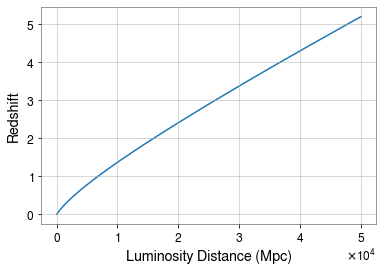

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1 * cost1 + a2 * q * cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)

luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)
luminosity_prior = luminosity_distances ** 2
dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

In [3]:
c = 3.0e8          # m/s
H_0 = 67270.0      # m/s/MPc
Omega_M = 0.3156 # unitless
Omega_Lambda = 1.0-Omega_M

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl, m1, m2):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    
    pz = np.power(1.+z,2.7-1.)*dVc_dz
    
    alpha = -2.2
    beta = 1.3
    mMin = 5.
    mMax = 75.
    
    pm1 = np.power(m1,alpha) #m1 and m2 are presumed to be in the **detector frame**
    pm2 = np.power(m2,beta)/(np.power(m1,1.+beta)-np.power(mMin,1.+beta))
    
    pASTRO = pz*pm1*pm2
    pASTRO[m2<mMin] = 0.
    pASTRO[m1>mMax] = 0.
    
    return pASTRO

In [4]:
from gwpopulation.utils import test

test()

Changed for the last time hopefully


## Selection Effects

In [5]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))

    ref_p_z = np.power(z, 2.)
    ref_p_m1 = np.power(m1, -2.35)
    ref_p_m2 = (1.+ 2.)*np.power(m2, 2.)/(m1**(1.+ 2.) - 2.**(1.+ 2.))
    ref_p_chieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        ref_p_chieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])
        
    new_p_z = np.power(z, 2.7)
    new_p_m1 = (1.+ (-2.2)) * np.power(m1, (-2.2))/(75.**(1.+(-2.2)) - 5.**(1.+(-2.2)))
    new_p_m2 = (1.+ 1.3) * np.power(m2, 1.3)/(m1**(1.+ 1.3) - 5.**(1.+ 1.3))

    pop_reweight = (ref_p_chieff * ref_p_m1 * ref_p_m2 * ref_p_z) / (new_p_m1 * new_p_m2 * new_p_z)
    pop_reweight[m1 < 5.] = 0.
    pop_reweight[m2 < 5.] = 0.

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        pop_reweight = xp.asarray(pop_reweight[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pop_reweight"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

### Posteriors

In [6]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()

i = 0
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
#     print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

In [7]:
# Sampling pdfs

for posterior in posteriors:
    
    # Joint prior for chi_eff and chi_p is posterior["joint_prior"]
    
    # Redshift prior
#     posterior["redshift_prior"] = redshift_prior(posterior['redshift'])
    
    # Weights
    pAstro = calculate_pASTRO(posterior["redshift"], posterior["luminosity_distance"], 
                              posterior["mass_1"], posterior["mass_2"])
#     pAstro[pAstro<0] = 0
    p_LAL = calculate_pLAL(posterior["redshift"], posterior["luminosity_distance"])

    posterior["weights"] = pAstro/p_LAL
#     # Mass prior 
#     PRIOR_VOLUME = ((100. - 2.) ** 2)/2
#     posterior["mass_prior"] = (posterior["mass_1"] * (1+posterior["redshift"])**2)/PRIOR_VOLUME
    


### Gaussian Spin Model

In [15]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] #/posterior["weights"]
    
# def chi_effective_kde(data):
#     chi_effective_kde = gaussian_kde(data["chi_eff"])
#     chi_eff_grid = np.linspace(-1,1,200)
#     chi_eff_norm = np.trapz(chi_effective_kde(chi_eff_grid),chi_eff_grid)
#     prob = chi_effective_kde(data["chi_eff"])/chi_eff_norm
    
#     return prob

In [16]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff])
    vt_func = injection_resampling_vt_spin
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

22:54 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [17]:
priors = PriorDict()

# # mass
# priors["alpha"] = -2.2
# priors["beta"] = 1.3
# priors["mmin"] = 5
# priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# # redshift
# priors["lamb"] = 2.7

In [18]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [19]:
for ii in range(20):
    likelihood.parameters.update(priors.sample())
    print(likelihood.parameters)
    print(likelihood.log_likelihood_ratio())

{'mu_chi_eff': 0.47099606855700715, 'sigma_chi_eff': 0.20448189666090352, 'mu_chi_p': 0.7000523163499798, 'sigma_chi_p': 0.3429434423146879, 'spin_covariance': -0.05615052802757381}
-1.7976931348623157e+308
{'mu_chi_eff': -0.8620131821500208, 'sigma_chi_eff': 0.9981419212161023, 'mu_chi_p': 0.1992103037447667, 'sigma_chi_p': 0.7091578159588641, 'spin_covariance': 0.6576092605829083}
-1.7976931348623157e+308
{'mu_chi_eff': -0.9859276460615929, 'sigma_chi_eff': 0.7685215862415065, 'mu_chi_p': 0.766282272179964, 'sigma_chi_p': 0.5135413545040296, 'spin_covariance': -0.223261682982971}
-1.7976931348623157e+308
{'mu_chi_eff': -0.9381189336916496, 'sigma_chi_eff': 0.5423958116873614, 'mu_chi_p': 0.021696689557387093, 'sigma_chi_p': 0.8365780724097573, 'spin_covariance': 0.44618450005084354}
-1.7976931348623157e+308
{'mu_chi_eff': -0.8405280861080433, 'sigma_chi_eff': 0.4904113467733735, 'mu_chi_p': 0.9318279959272295, 'sigma_chi_p': 0.5052986707441489, 'spin_covariance': -0.24642320265207962

In [13]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin", outdir = "Results/gaussian_spin", clean = True)

22:51 bilby INFO    : Running for label 'gaussian_spin', output will be saved to 'Results/gaussian_spin'
22:51 bilby INFO    : Search parameters:
22:51 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
22:51 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
22:51 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
22:51 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
22:51 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
22:51 bilby INFO    : Single likelihood evaluation took 4.250e-03 s


0it [00:00, ?it/s]

22:51 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fcb02872490>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
22:51 bilby INFO    : Checkpoint every check_point_delta_t = 600s
22:51 bilby INFO    : Using dynesty version 1.0.1
22:51 bilby INFO    : Using the bilby-implemented rwalk sam

AttributeError: 'Dynesty' object has no attribute 'sampler'

In [ ]:
result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.004970501466413499
mu_chi_eff mu_chi_p 0.008572906747042162
mu_chi_eff sigma_chi_p 0.011183618742658975
mu_chi_eff spin_covariance 0.014852288210081917


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.011867919692885648
sigma_chi_eff sigma_chi_p 0.015482063788868452
sigma_chi_eff spin_covariance 0.020560793314783228


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.026702796490571622
mu_chi_p spin_covariance 0.035462370331022224


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.046261745426073655


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


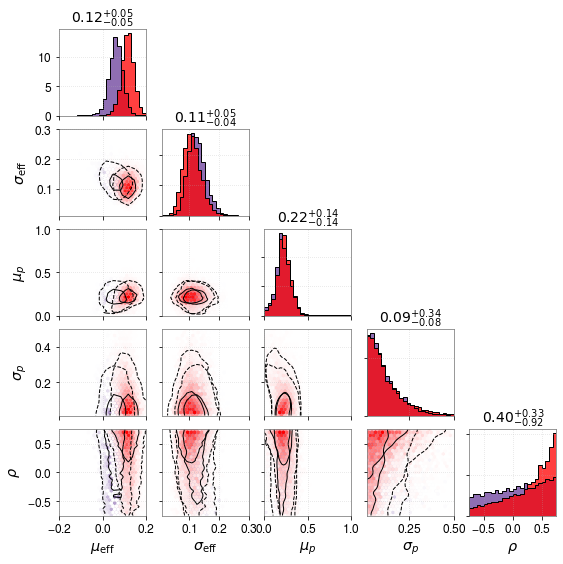

In [25]:
from plots import *

overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/gaussian_spin/gaussian_spin_result.json", "spin_vt", save = False)

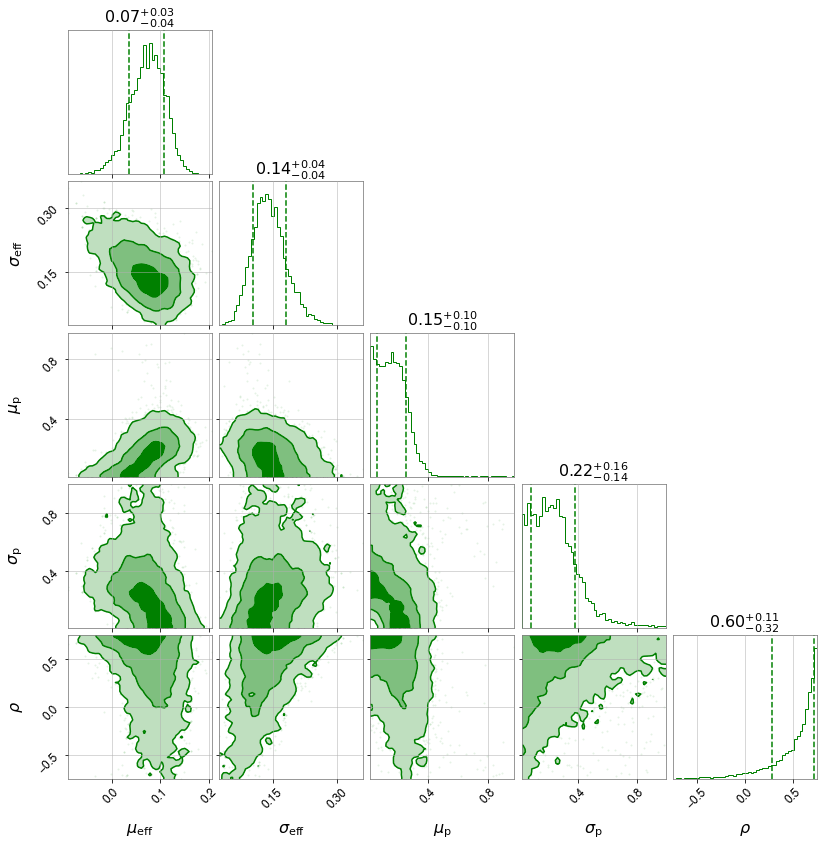

In [13]:
# Only using spin model with selection effects_sigma_swap

result.plot_corner(color = 'g')

In [14]:
from bilby.core.result import read_in_result 
import matplotlib.pyplot as plt
import corner
import json
import matplotlib
import numpy as np


def plot_corner(fig,plot_data,color,hist_alpha=0.7,bins=20,mirror=True,kdewidth=1.):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling
    # - "priors" : Tuple of min/max prior bounds

    # Define a linear color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color])
    
    # Loop across dimensions that we want to plot
    keys = list(plot_data)    
    ndim = len(keys)
    for i,key in enumerate(keys):
       
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        ax.set_rasterization_zorder(1)
        
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds']  [1],bins),\
               rasterized=True,color=color,alpha=hist_alpha,density=True,zorder=0)
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
                histtype='step',color='black',density=True,zorder=2)
        ax.grid(True,dashes=(1,3))
        ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
        ax.set_title(r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(*getBounds(plot_data[key]['data'])),fontsize=14)

        # Turn off tick labels if this isn't the first dimension
        if i!=0:
            ax.set_yticklabels([])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'])
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
            
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                ax.set_rasterization_zorder(1)
                
                ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                         linewidths=(0,),zorder=0)

                # The rest of this "for" loop involves code to additionally add contours.
                # First, reflect data across all boundaries to have reasonable edge conditions
                if mirror:
                    mirrored_x,mirrored_y = mirrorData(plot_data[key]['data'],plot_data[k]['data'],plot_data[key]['priors'],plot_data[k]['priors'])            
                else:
                    mirrored_x = plot_data[key]['data']
                    mirrored_y = plot_data[k]['data']                
                
                # In drawing contours, we'll also need to KDE the data
                # Different dimensions will naturally want different KDE bandwidths.
                # To get reasonable-looking contours, reach a "compromise" between the two dimensions in question
                kde_width1 = np.std(plot_data[key]['data'])*np.power(float(len(plot_data[key]['data'])),-1./6.)/np.std(mirrored_x)
                kde_width2 = np.std(plot_data[k]['data'])*np.power(float(len(plot_data[k]['data'])),-1./6.)/np.std(mirrored_y)
                kde_width = kdewidth*np.sqrt(kde_width1*kde_width2)                
                print(key,k,kde_width)
                kde = gaussian_kde([mirrored_x,mirrored_y],bw_method=kde_width)

                # Make a regular grid and evaluate the KDE
                x_gridpoints = np.linspace(plot_data[key]['priors'][0],plot_data[key]['priors'][1],60)
                y_gridpoints = np.linspace(plot_data[k]['priors'][0],plot_data[k]['priors'][1],59)
                x_grid,y_grid = np.meshgrid(x_gridpoints,y_gridpoints)
                z_grid = kde([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

                # Find the probabilities corresponding to central 50% and 90% probabilities
                sortedVals = np.sort(z_grid.flatten())[::-1]
                cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
                i50 = np.argmin(np.abs(cdfVals - 0.50))
                i90 = np.argmin(np.abs(cdfVals - 0.90))
                val50 = sortedVals[i50]
                val90 = sortedVals[i90]
                
                # Draw contours
                CS = ax.contour(x_gridpoints,y_gridpoints,z_grid,levels=(val90,val50),linestyles=     ('dashed','solid'),colors='k',linewidths=1,zorder=2)
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'])
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'])
                else:
                    ax.set_xticklabels([])
                    
    plt.tight_layout()    
    return fig

def getBounds(data):
    
    # Transform to a numpy arry
    data = np.array(data)

    # Get median, 5% and 95% quantiles
    med = np.median(data)
    upperLim = np.sort(data)[int(0.95*data.size)]
    lowerLim = np.sort(data)[int(0.05*data.size)]
 
    # Turn quantiles into upper and lower uncertainties
    upperError = upperLim-med
    lowerError = med-lowerLim
    
    return med,upperError,lowerError

def mirrorData(ref_data_x,ref_data_y,x_priors,y_priors):
    
    low_x,high_x = x_priors
    low_y,high_y = y_priors
        
    # Original data
    data_x = np.copy(ref_data_x)
    data_y = np.copy(ref_data_y)
    data_x_mirrored = np.copy(data_x)
    data_y_mirrored = np.copy(data_y)
    
    # Left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,data_y)
    
    # Right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,data_y)   
    
    # Top
    data_x_mirrored = np.append(data_x_mirrored,data_x)
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))
    
    # Bottom
    data_x_mirrored = np.append(data_x_mirrored,data_x)
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))
    
    # Upper left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))

    # Lower left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))

    # Upper right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))

    # Lower right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))
    
    return data_x_mirrored,data_y_mirrored


def overlayed_plot_(result_O3a_file, result1_file, filename, save = False):
    with open(result_O3a_file,'r') as ff1:
        data1 = json.load(ff1)

    plot_data1 = {
        'mu_eff':{'data':data1['mu_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_eff':{'data':data1['sigma_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_p':{'data':data1['mu_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_p':{'data':data1['sigma_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'corr':{'data':data1['corr'],'plot_bounds':(-0.75,0.75),'priors':(-0.75,0.75),'label':r'$\rho$'}}
    
    with open(result1_file,'r') as ff2:
        data2 = json.load(ff2)

    plot_data2 = {
        'mu_chi_eff':{'data':data2['posterior']['content']['mu_chi_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_chi_eff':{'data':data2['posterior']['content']['sigma_chi_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_chi_p':{'data':data2['posterior']['content']['mu_chi_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_chi_p':{'data':data2['posterior']['content']['sigma_chi_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'spin_covariance':{'data':data2['posterior']['content']['spin_covariance'],'plot_bounds':(-0.75,0.75),'priors':(-0.75,0.75),'label':r'$\rho$'}}
    
    fig = plt.figure(figsize=(12,12))
    plot_corner(fig,plot_data1,"#6a3d9a",bins=25,hist_alpha=0.75)
    plot_corner(fig,plot_data2,"#FF0000",bins=25,hist_alpha=0.75)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.18, hspace=0.16)
    if save == True:
        filename = "./Overlayed_Plots/" + filename
        fig.savefig(filename, dpi=400)
    plt.show()

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


<ipython-input-14-a33a2909358f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-14-a33a2909358f>:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.005106921580607796
mu_chi_eff mu_chi_p 0.008875369386040638
mu_chi_eff sigma_chi_p 0.010865820907436582
mu_chi_eff spin_covariance 0.015217761655940406


<ipython-input-14-a33a2909358f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-14-a33a2909358f>:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.01189172609081919
sigma_chi_eff sigma_chi_p 0.014558646560261668
sigma_chi_eff spin_covariance 0.020389624978588552


<ipython-input-14-a33a2909358f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-14-a33a2909358f>:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.025301615453385138
mu_chi_p spin_covariance 0.035435330359287975


<ipython-input-14-a33a2909358f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-14-a33a2909358f>:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.04338230182120225


<ipython-input-14-a33a2909358f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


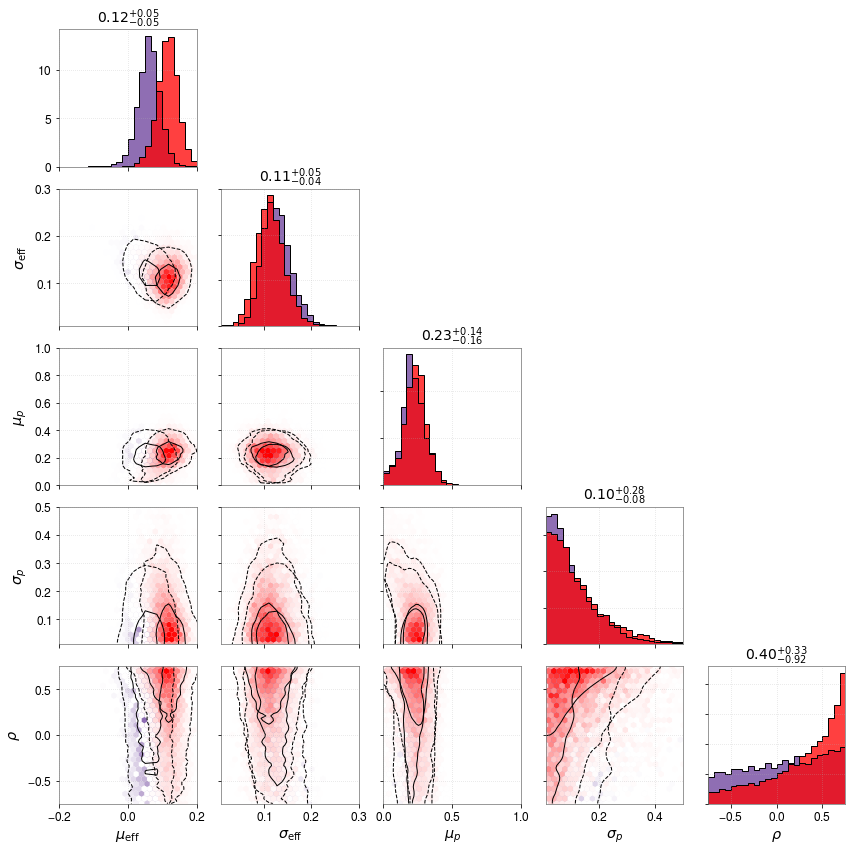

In [15]:
# from plots import *
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_spin/gaussian_spin_result.json", "spin_vt", save = True)

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.0064745274867000204
mu_chi_eff mu_chi_p 0.009864290069868529
mu_chi_eff sigma_chi_p 0.013014962102648481
mu_chi_eff spin_covariance 0.013346202378258159


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.014219812795501975
sigma_chi_eff sigma_chi_p 0.018761646639480947
sigma_chi_eff spin_covariance 0.019239144226852977


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.028584375465296238
mu_chi_p spin_covariance 0.029311868663707354


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.038674132361665774


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


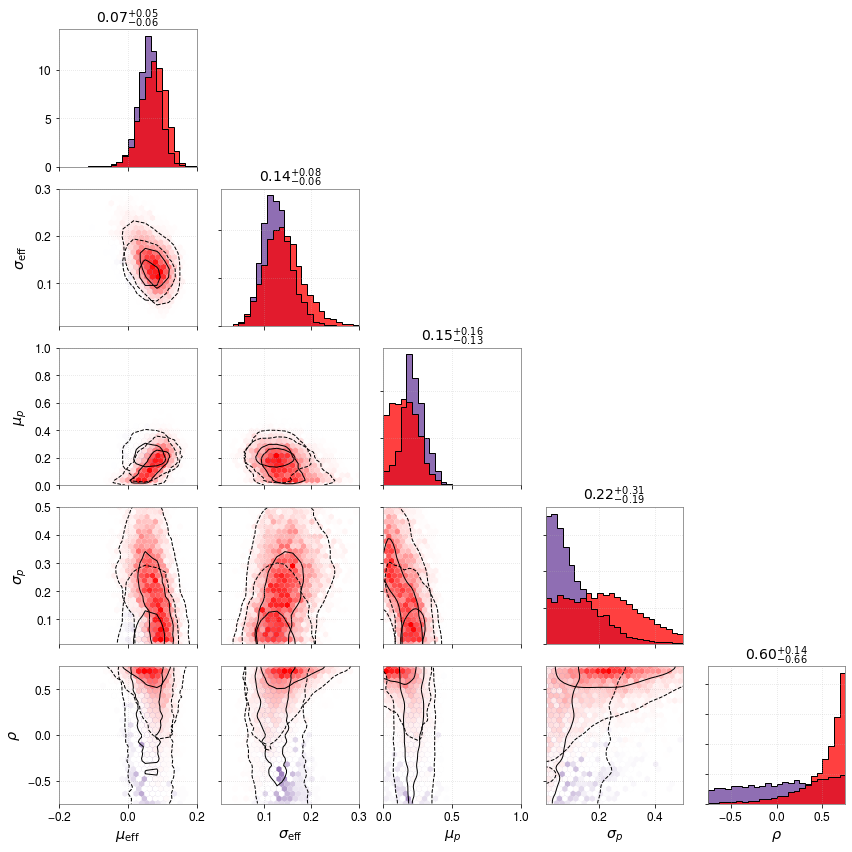

In [16]:
from plots import *
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_spin_vt/gaussian_spin_vt_result.json", "spin_vt", save = True)

### Gaussian Spin Model + Truncated Mass Model

In [7]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"]

In [8]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff, 
                      mass.power_law_primary_mass_ratio])
    vt_func = injection_resampling_vt_spin_mass
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

12:14 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [19]:
# priors = PriorDict()

# # mass
# priors["alpha"] = Uniform(minimum = -4, maximum = 12, latex_label =r'$\alpha$')
# priors["beta"] = Uniform(minimum = -4, maximum = 12, latex_label =r'$\beta_\mathrm{q}$')
# priors["mmin"] = Uniform(minimum = 2, maximum = 10, latex_label =r'$m_\mathrm{min}$ $[M_\odot]$')
# priors["mmax"] = Uniform(minimum = 30, maximum = 100, latex_label =r'$m_\mathrm{max}$ $[M_\odot]$')

# # spin
# priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
# priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
# priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
# priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
# priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [9]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [10]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [11]:
likelihood.parameters.update(priors.sample())

In [12]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin_mass_vt", 
                           outdir = "gaussian_spin_mass_vt", clean = True)

12:15 bilby INFO    : Running for label 'gaussian_spin_mass_vt', output will be saved to 'gaussian_spin_mass_vt'
12:15 bilby INFO    : Search parameters:
12:15 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
12:15 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
12:15 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
12:15 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
12:15 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
12:15 bilby INFO    :   alpha = -2.2
12:15 bilby INFO    :   beta = 1.3
12:15 bilby INFO    :   mmin = 5
12:15 bilby INFO    :   mmax

0it [00:00, ?it/s]

12:15 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd2583a6f70>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:15 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:15 bilby INFO    : Using dynesty version 1.0.1
12:15 bilby INFO    : Using the bilby-implemented rwalk sam

13:44 bilby INFO    : Sampling time: 1:28:45.038289
13:44 bilby INFO    : Summary of results:
nsamples: 15313
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.136
ln_bayes_factor: 271.755 +/-  0.136



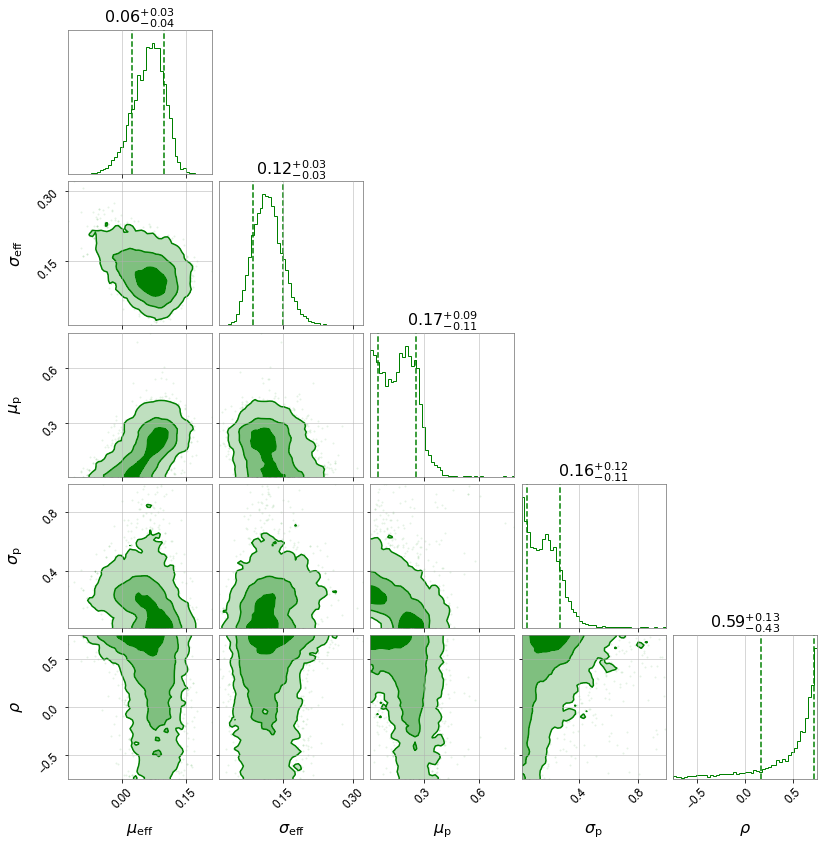

In [13]:
# Gaussian Spin + Truncated Mass model with selection effects

result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.0057527034671848
mu_chi_eff mu_chi_p 0.009753369882957684
mu_chi_eff sigma_chi_p 0.01094553932519971
mu_chi_eff spin_covariance 0.014912395621253044


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.012414567847113235
sigma_chi_eff sigma_chi_p 0.013932019620559219
sigma_chi_eff spin_covariance 0.018981228993122094


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.023620918643045483
mu_chi_p spin_covariance 0.0321815557257704


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.03611515691187019


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


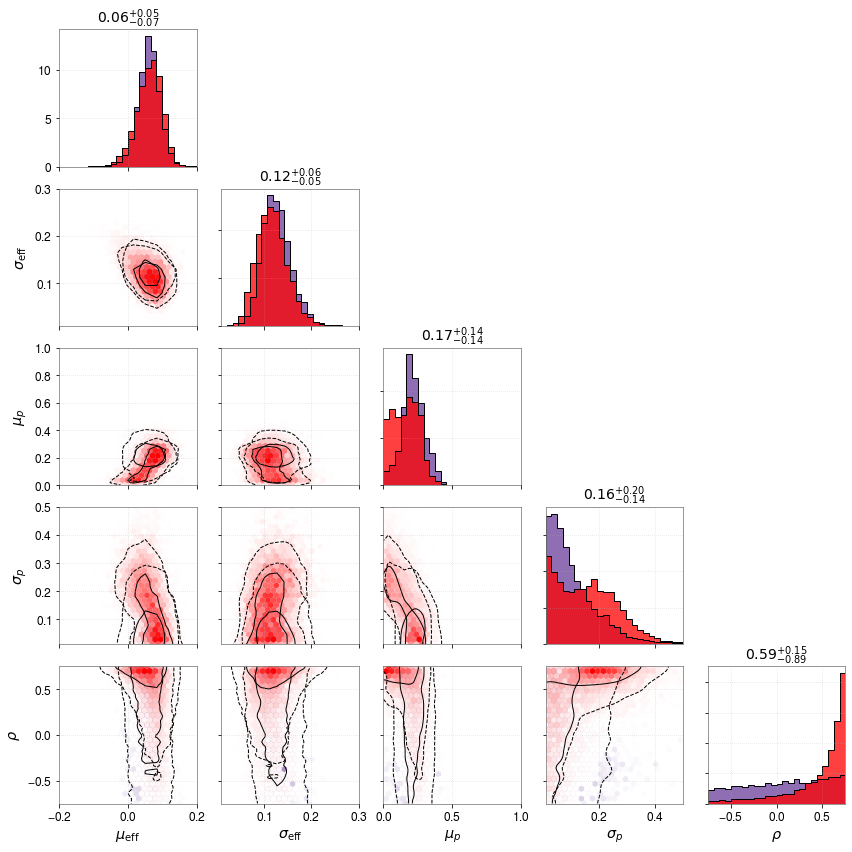

In [14]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_spin_mass_vt/gaussian_spin_mass_vt_result.json", "spin_mass_vt", save = True)

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.00578383650606897
mu_chi_eff mu_chi_p 0.00908712159909875
mu_chi_eff sigma_chi_p 0.011021448165103696
mu_chi_eff spin_covariance 0.012146061779075694


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.01320011600907746
sigma_chi_eff sigma_chi_p 0.01600995351287383
sigma_chi_eff spin_covariance 0.01764358744281822


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.025153614597291287
mu_chi_p spin_covariance 0.027720255295769082


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-15-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.033620916539298974


<ipython-input-15-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


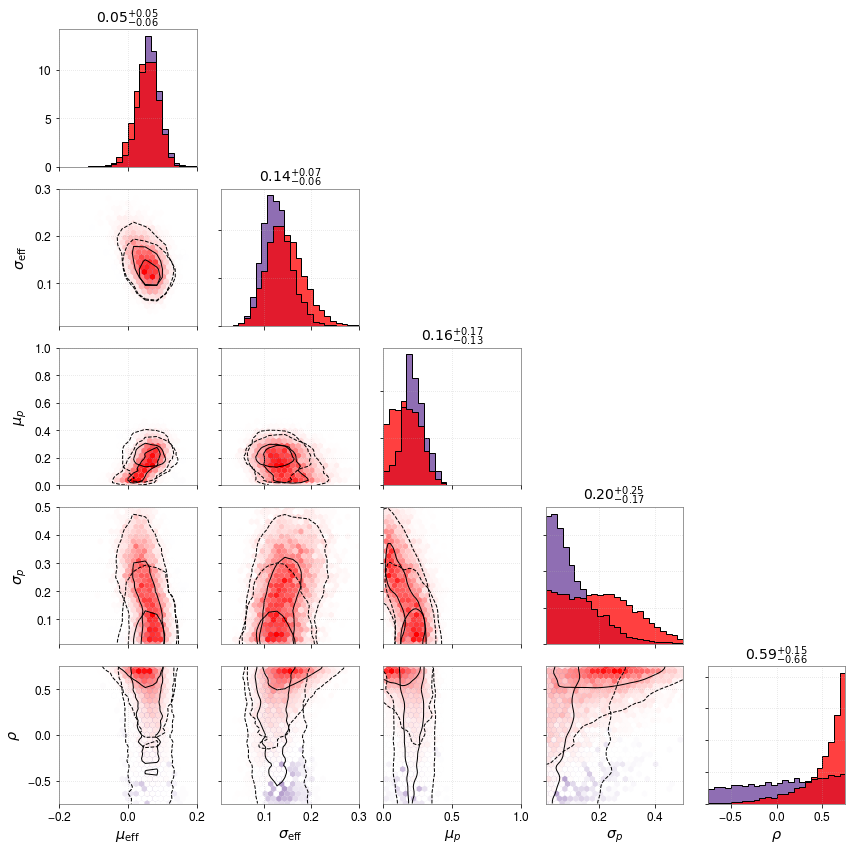

In [24]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_spin_mass_vt/gaussian_spin_mass_vt_result.json", "spin_mass_vt", save = True)

### Gaussian Spin Model + Truncated Mass Model + PowerLaw Redshift Model

In [8]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"] * posterior["redshift_prior"]

In [9]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff, 
                      mass.power_law_primary_mass_ratio,
                      redshift.PowerLawRedshift()])
    vt_func = injection_resampling_vt_spin_mass_redshift
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

21:19 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [10]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [11]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [12]:
likelihood.parameters.update(priors.sample())

In [13]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin_truncated_mass_powerlaw_redshift_vt", 
                           outdir = "gaussian_spin_truncated_mass_powerlaw_redshift_vt", clean = True)

21:21 bilby INFO    : Running for label 'gaussian_spin_truncated_mass_powerlaw_redshift_vt', output will be saved to 'gaussian_spin_truncated_mass_powerlaw_redshift_vt'
21:21 bilby INFO    : Search parameters:
21:21 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
21:21 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
21:21 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
21:21 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
21:21 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
21:21 bilby INFO    :   alpha = -2.2
21:21 bilby INFO    :   beta = 1.3
21:21

0it [00:00, ?it/s]

21:21 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fe2b804dd00>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
21:21 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:21 bilby INFO    : Using dynesty version 1.0.1
21:21 bilby INFO    : Using the bilby-implemented rwalk sam

23:16 bilby INFO    : Sampling time: 1:54:09.235059
23:16 bilby INFO    : Summary of results:
nsamples: 15480
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.137
ln_bayes_factor: -1207.667 +/-  0.137



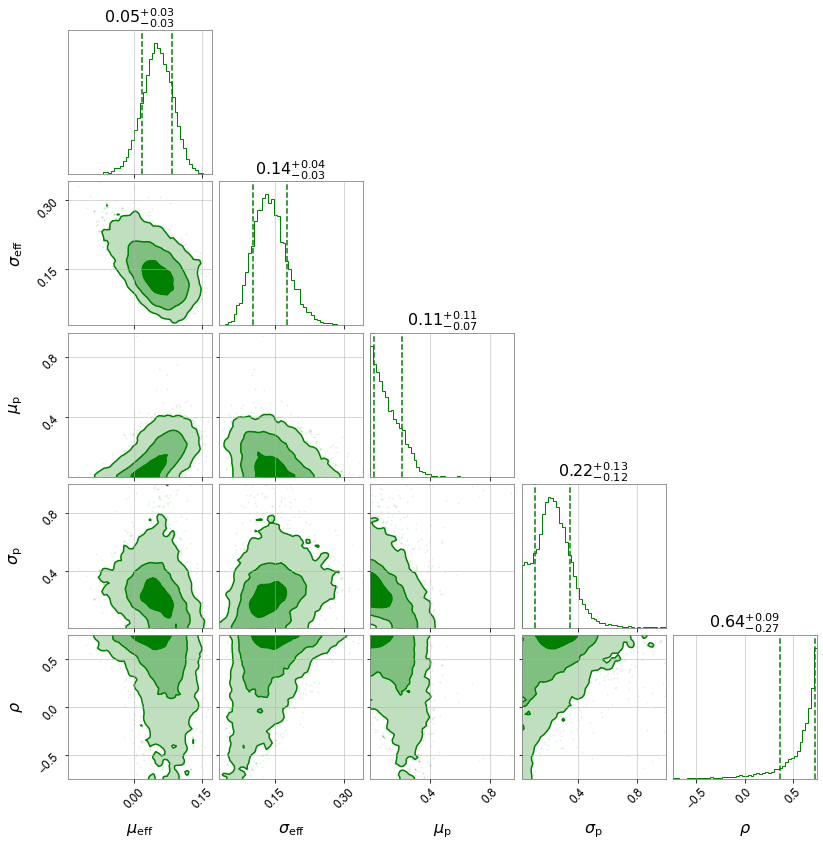

In [14]:
# Gaussian Spin + Truncated Mass + Powerlaw Reshift model with selection effects

result.plot_corner(color = 'g')

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


<ipython-input-7-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-7-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.006016187662202262
mu_chi_eff mu_chi_p 0.009042306556086233
mu_chi_eff sigma_chi_p 0.011118201356262715
mu_chi_eff spin_covariance 0.012274529384208855


<ipython-input-7-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-7-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.01303490688224278
sigma_chi_eff sigma_chi_p 0.016027406113472604
sigma_chi_eff spin_covariance 0.01769430692867005


<ipython-input-7-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-7-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.024089128782904236
mu_chi_p spin_covariance 0.02659447419696134


<ipython-input-7-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
<ipython-input-7-0ab123c18c21>:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.03269992200018147


<ipython-input-7-0ab123c18c21>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


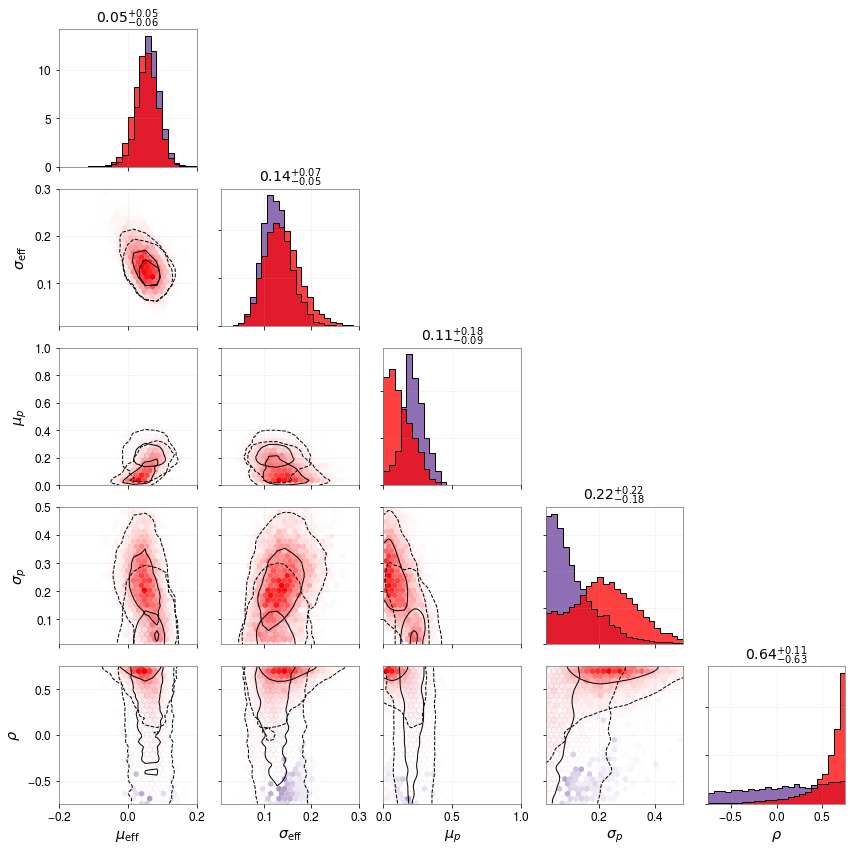

In [15]:
overlayed_plot("O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
               "gaussian_spin_truncated_mass_powerlaw_redshift_vt/gaussian_spin_truncated_mass_powerlaw_redshift_vt_result.json", 
               "spin_mass_redshift_vt", save = True)

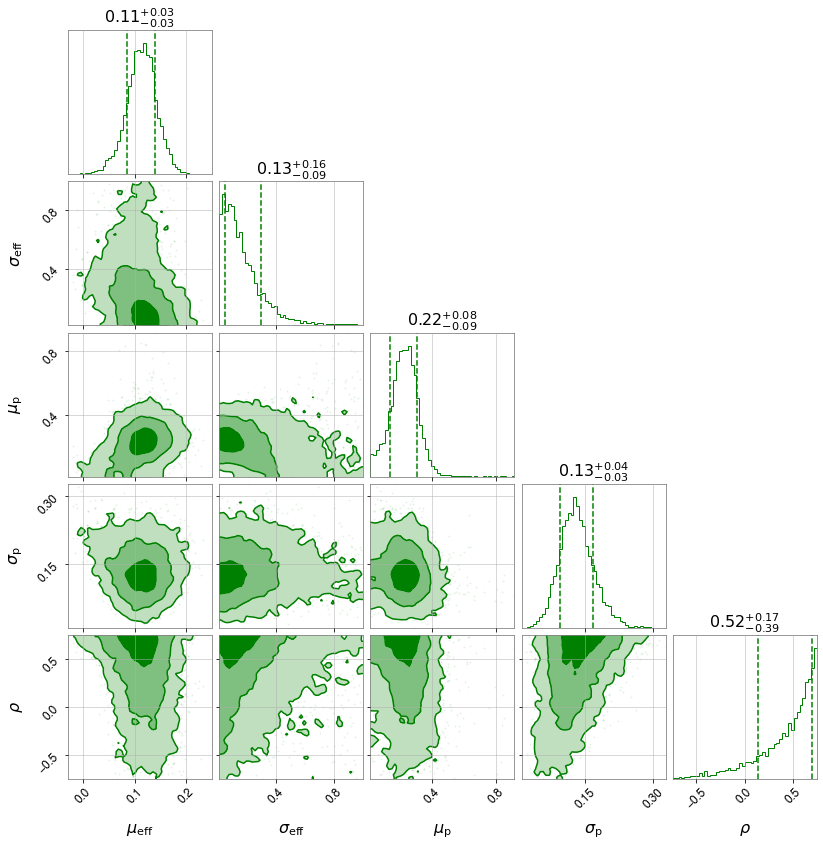

In [11]:
# Only using spin model without selection effects
# This plot is wrong. Run this again cause the bug in Gaussian model is fixed now.

result_joint.plot_corner(color = 'g')

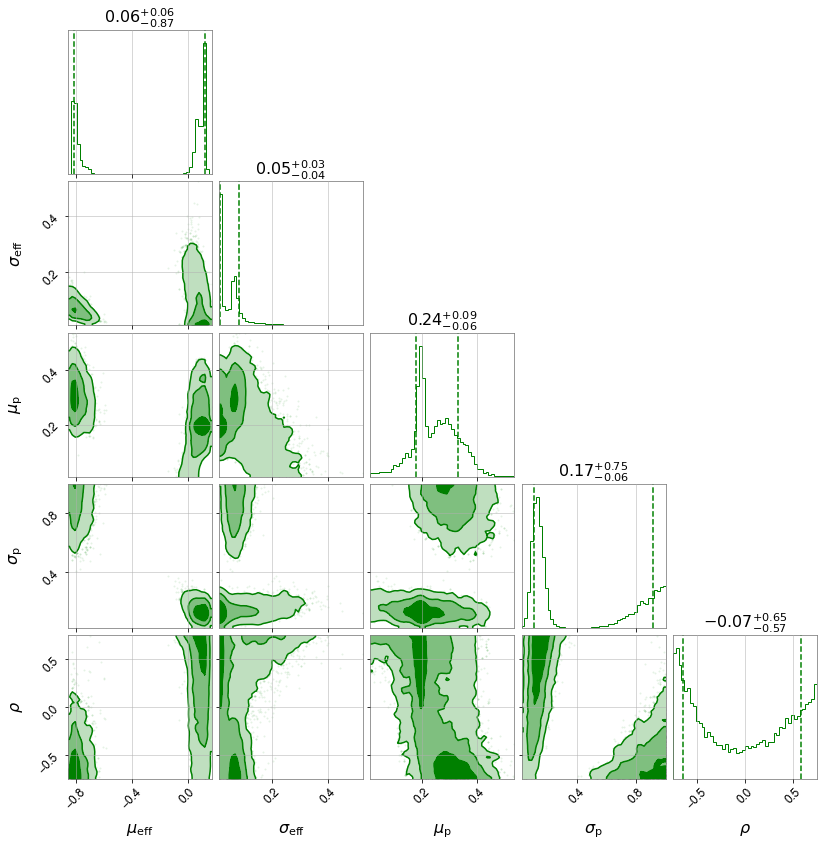

In [12]:
# Gaussian Spin + Truncated Mass model(with fixed hyperparameters alpha = -2.2, beta = 1.3, mmin = 5, mmax = 75) 
# with selection effects 

result.plot_corner(color = 'g')

In [4]:
priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [5]:
# Coding the Gaussian model again:

def unnormalized_2d_gaussianmy(xx, yy, mu_x, mu_y, sigma_x, sigma_y, covariance):
    determinant = sigma_x ** 2 * sigma_y ** 2 * (1 - covariance)
    residual_x = (xx - mu_x) * sigma_y
    residual_y = (yy - mu_y) * sigma_x
    prob = xp.exp(-(residual_x ** 2 + residual_y ** 2 - (2*residual_x*residual_y*covariance))/ (2*determinant))
                  
    return prob

class GaussianChiEffChiPmy(object):

    def __init__(self):
        self.chi_eff = xp.linspace(-1, 1, 500)
        self.chi_p = xp.linspace(0, 1, 250)
        self.chi_eff_grid, self.chi_p_grid = xp.meshgrid(self.chi_eff, self.chi_p)

    def __call__(
        self, dataset, mu_chi_eff, sigma_chi_eff, mu_chi_p, sigma_chi_p, spin_covariance
    ):
        if spin_covariance == 0:
            prob = gaussian_chi_eff(
                dataset=dataset,
                mu_chi_eff=mu_chi_eff,
                sigma_chi_eff=sigma_chi_eff,
            )
            prob *= gaussian_chi_p(
                dataset=dataset, mu_chi_p=mu_chi_p, sigma_chi_p=sigma_chi_p
            )
        else:
            prob = unnormalized_2d_gaussian(
                dataset["chi_eff"],
                dataset["chi_p"],
                mu_chi_eff,
                mu_chi_p,
                sigma_chi_eff,
                sigma_chi_p,
                spin_covariance,
            )
            normalization = self._normalization(
                mu_chi_eff=mu_chi_eff,
                sigma_chi_eff=sigma_chi_eff,
                mu_chi_p=mu_chi_p,
                sigma_chi_p=sigma_chi_p,
                spin_covariance=spin_covariance,
            )
            prob /= normalization
        return prob

    def _normalization(
        self, mu_chi_eff, sigma_chi_eff, mu_chi_p, sigma_chi_p, spin_covariance
    ):
        prob = unnormalized_2d_gaussian(
            self.chi_eff_grid,
            self.chi_p_grid,
            mu_chi_eff,
            mu_chi_p,
            sigma_chi_eff,
            sigma_chi_p,
            spin_covariance,
        )
        return xp.trapz(
            y=xp.trapz(y=prob, axis=-1, x=self.chi_eff), axis=-1, x=self.chi_p
        )

In [6]:
par = priors.sample(1000)
par = pd.DataFrame.from_dict(par)
par

,mu_chi_eff,sigma_chi_eff,mu_chi_p,sigma_chi_p,spin_covariance
0,0.668488,0.710688,0.559269,0.390550,-0.104866
1,0.401248,0.750906,0.497013,0.103351,0.281211
2,-0.653156,0.163955,0.067163,0.066101,0.684669
3,-0.248547,0.557891,0.473214,0.571418,-0.650270
4,0.699134,0.506461,0.289246,0.252134,-0.413278
...,...,...,...,...,...
995,-0.133230,0.503199,0.133772,0.475088,-0.735680
996,-0.921784,0.641124,0.604325,0.464164,0.512195
997,0.943058,0.283314,0.033581,0.884928,-0.044605
998,-0.992843,0.175952,0.460858,0.916255,-0.737439


In [10]:
posteriors[0]

,mass_1,mass_2,mass_ratio,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,chi_eff,chi_p,redshift,joint_prior,mass_prior,redshift_prior
0,24.777434,21.754348,0.877990,1069.54740,0.553222,0.310523,-0.382521,0.945086,0.024518,0.511148,0.210624,2.263800,0.003781,5.408459e+09
1,21.656837,18.564400,0.857207,1849.46880,0.777600,0.520862,-0.372569,-0.029071,-0.162981,0.721617,0.340266,1.668516,0.004051,1.622103e+10
2,21.325763,20.967088,0.983181,1575.04720,0.473670,0.634391,0.324260,-0.274648,-0.008931,0.598285,0.296178,2.066506,0.003731,1.177655e+10
3,22.898892,18.998009,0.829648,2017.98170,0.758463,0.402229,0.436187,-0.671067,0.058422,0.682507,0.366658,2.130796,0.004453,1.929060e+10
4,23.285279,21.044542,0.903770,1478.81770,0.817927,0.388688,-0.358257,0.683172,-0.027860,0.763636,0.280357,1.900759,0.003975,1.037984e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37361,30.301706,15.540542,0.512860,1509.09400,0.108830,0.716262,0.583490,0.021557,0.047209,0.334955,0.285356,2.983951,0.005213,1.080876e+10
37362,24.709623,15.536710,0.628772,1314.77280,0.491680,0.156617,-0.843884,-0.635701,-0.293179,0.263799,0.252909,1.043780,0.004039,8.197065e+09
37363,20.364448,20.021941,0.983181,1958.28880,0.473670,0.634391,0.324260,-0.274648,-0.008931,0.598285,0.357364,2.166257,0.003907,1.817440e+10
37364,24.043337,20.671754,0.859771,1049.86510,0.290820,0.055537,-0.263955,-0.804390,-0.061928,0.280506,0.207159,2.180991,0.003648,5.206129e+09


In [24]:
prob = []
for i in range(len(par)):
    p = unnormalized_2d_gaussianmy(xp.array(posteriors[0]["chi_eff"]), xp.array(posteriors[0]["chi_p"]), 
                                   par["mu_chi_eff"][i], par["mu_chi_p"][i], 
                                   par["sigma_chi_eff"][i], par["sigma_chi_p"][i], 
                                   par["spin_covariance"][i])
    prob.append(p)
    
prob = np.array(prob) 
# print(prob)

OutOfMemoryError: Out of memory allocating 299,008 bytes (allocated so far: 16,412,500,480 bytes).

In [ ]:
x = posteriors[0]["chi_eff"]
y = posteriors[0]["chi_p"]
points = np.column_stack([x, y])